In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [38]:
df = pd.read_csv('/content/drive/MyDrive/UU/BNB-USD (BaoCao).csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-01,10.356931,11.607489,10.325634,11.393217,11.393217,117838677
1,2019-03-02,11.384693,11.915753,10.960816,11.869744,11.869744,120807894
2,2019-03-03,11.845305,11.964979,11.352064,11.537903,11.537903,89868246
3,2019-03-04,11.538013,11.599405,11.070543,11.545945,11.545945,89421231
4,2019-03-05,11.520388,13.841443,11.520388,13.811967,13.811967,237026335


In [39]:

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [40]:
df_Close = df[['Close']]
df_Close = df_Close.reset_index(drop=True)

In [41]:
# Chuẩn hóa dữ liệu
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Close).reshape(-1, 1))

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1920 entries, 2019-03-01 to 2024-06-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1920 non-null   float64
 1   High       1920 non-null   float64
 2   Low        1920 non-null   float64
 3   Close      1920 non-null   float64
 4   Adj Close  1920 non-null   float64
 5   Volume     1920 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 105.0 KB


In [43]:
cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']  # Correct the column name 'Adj Close'
df = df[cols]
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-03-01,10.356931,11.607489,10.325634,11.393217,11.393217,117838677
2019-03-02,11.384693,11.915753,10.960816,11.869744,11.869744,120807894
2019-03-03,11.845305,11.964979,11.352064,11.537903,11.537903,89868246
2019-03-04,11.538013,11.599405,11.070543,11.545945,11.545945,89421231
2019-03-05,11.520388,13.841443,11.520388,13.811967,13.811967,237026335


In [44]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def calculate_vif(df):
    """Calculate Variance Inflation Factor (VIF) for each variable."""
    vif_df = pd.DataFrame()
    vif_df["variables"] = df.columns
    vif_df["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_df

def cointegration_test(df, alpha=0.05, max_vif=10):
    """Perform Johanson's Cointegration Test and Report Summary"""
    # Convert numeric columns to float
    df_numeric = df.select_dtypes(include=['number']).astype(float)

    # Drop any columns with all zero values
    df_numeric = df_numeric.loc[:, (df_numeric != 0).any(axis=0)]

    # Drop constant columns to handle perfect multicollinearity
    df_numeric = df_numeric.loc[:, (df_numeric != df_numeric.iloc[0]).any()]

    # Calculate VIF and drop columns with VIF higher than the threshold
    while True:
        vif_df = calculate_vif(df_numeric)
        max_vif_value = vif_df['VIF'].max()
        if max_vif_value > max_vif:
            remove_col = vif_df.sort_values('VIF', ascending=False)['variables'].iloc[0]
            print(f"Removing {remove_col} with VIF {max_vif_value}")
            df_numeric = df_numeric.drop(columns=[remove_col])
        else:
            break

    out = coint_johansen(df_numeric, -1, 5)
    d = {'0.90': 0, '0.95': 1, '0.99': 2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]

    def adjust(val, length=6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df_numeric.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace, 2), 9), ">", adjust(cvt, 8), ' =>  ', trace > cvt)

# Example usage with your dataframe df
cointegration_test(df)

Removing Close with VIF inf
Removing High with VIF 4765.936225312949
Removing Low with VIF 2522.1470798076557
Removing Adj Close with VIF 477.6987872539529
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Open   ::  45.9      > 12.3212   =>   True
Volume ::  0.0       > 4.1296    =>   False


In [45]:
df = df.sort_values(by='Date', ascending=True)

In [84]:
# Train, test
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR

time_series = df[cols]
train_data = time_series[:int(0.7*len(time_series))]
test_data = time_series[int(0.7*len(time_series)):]

Error fitting model with lag 3. Skipping.
Error fitting model with lag 6. Skipping.


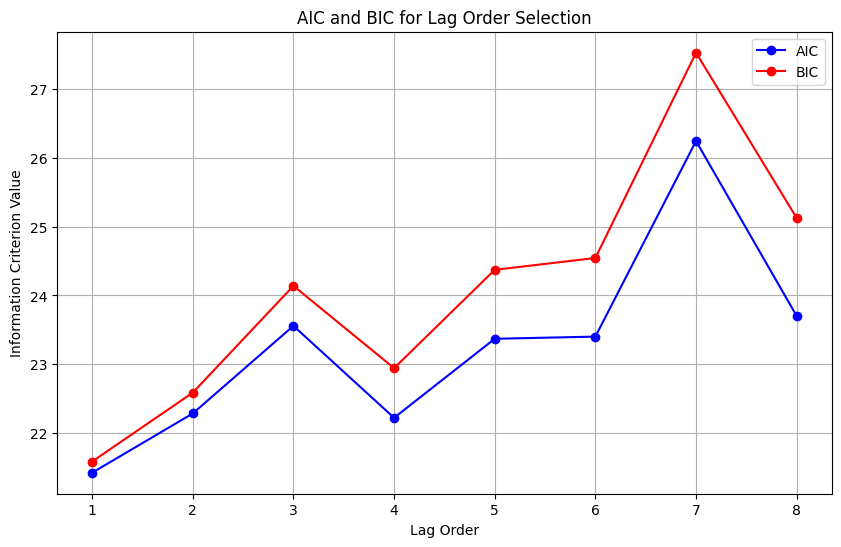

Optimal lag order based on AIC: 1
Optimal lag order based on BIC: 1


In [85]:
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import aic, bic
import numpy as np

# Tạo danh sách các giá trị lag order cần kiểm tra
maxlags = 10  # Số lượng lag order tối đa để kiểm tra

# Khởi tạo list để lưu trữ các giá trị AIC và BIC
aic_values = []
bic_values = []

for lag in range(1, maxlags+1):
    model = VAR(train_data)
    try:
        results = model.fit(lag)
        aic_values.append(results.aic)
        bic_values.append(results.bic)
    except np.linalg.LinAlgError:
        print(f"Error fitting model with lag {lag}. Skipping.")
        continue  # Skip to the next lag if an error occurs

# Vẽ đồ thị AIC và BIC (only if any models were successfully fit)
if aic_values:  # Check if aic_values is not empty
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(range(1, len(aic_values) + 1), aic_values, marker='o', linestyle='-', color='b', label='AIC')
    plt.plot(range(1, len(bic_values) + 1), bic_values, marker='o', linestyle='-', color='r', label='BIC')
    plt.xlabel('Lag Order')
    plt.ylabel('Information Criterion Value')
    plt.title('AIC and BIC for Lag Order Selection')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Tìm lag order tối ưu dựa trên AIC hoặc BIC
    optimal_lag_aic = np.argmin(aic_values) + 1  # +1 vì index bắt đầu từ 0
    optimal_lag_bic = np.argmin(bic_values) + 1  # +1 vì index bắt đầu từ 0

    print(f'Optimal lag order based on AIC: {optimal_lag_aic}')
    print(f'Optimal lag order based on BIC: {optimal_lag_bic}')
else:
    print("No models could be fit successfully. Check for multicollinearity or singularity issues in your data.")

In [86]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [87]:
# ADF Test on each column
df_diff = df.diff().dropna()  # Calculate first differences and drop missing values

for name, column in df_diff.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.1882
 No. Lags Chosen       = 24
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.3956
 No. Lags Chosen       = 10
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Low" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.0

In [88]:
import warnings
warnings.filterwarnings("ignore")

In [89]:
df_diff = train_data.diff().dropna()
df_diff

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-03-02,1.027762,0.308264,0.635182,0.476527,0.476527,2969217.0
2019-03-03,0.460612,0.049226,0.391248,-0.331841,-0.331841,-30939648.0
2019-03-04,-0.307292,-0.365574,-0.281521,0.008042,0.008042,-447015.0
2019-03-05,-0.017625,2.242038,0.449845,2.266022,2.266022,147605104.0
2019-03-06,2.229900,0.714014,1.592283,0.705979,0.705979,-46009513.0
...,...,...,...,...,...,...
2022-10-30,6.226135,10.154297,6.589112,9.536834,9.536834,54179292.0
2022-10-31,9.441437,18.726044,5.090973,12.605927,12.605927,716855740.0
2022-11-01,12.606507,-2.589081,10.310180,-1.781281,-1.781281,-839295308.0


In [90]:
# ADF Test on each column
for name, column in df_diff.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.1778
 No. Lags Chosen       = 23
 Critical value 1%     = -3.435
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.0892
 No. Lags Chosen       = 14
 Critical value 1%     = -3.435
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Low" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05

In [91]:
model = VAR(df_diff)

In [92]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Assuming df_diff is your differenced DataFrame

# ADF Test on each column
for name, column in df_diff.items():
    result = adfuller(column) # Remove the 'name' argument
    print(f'ADF Statistic for {name}: {result[0]}') # Use f-string to print the name
    print(f'p-value: {result[1]}')
    print('\n')

# Check for multicollinearity
correlation_matrix = df_diff.corr()
print(correlation_matrix)

ADF Statistic for Open: -7.177794168986647
p-value: 2.698731577531357e-10


ADF Statistic for High: -9.089163154812296
p-value: 3.866198489559815e-15


ADF Statistic for Low: -7.304565533534973
p-value: 1.3117733285554258e-10


ADF Statistic for Close: -7.183455544890107
p-value: 2.613426092988764e-10


ADF Statistic for Adj Close: -7.183455544890107
p-value: 2.613426092988764e-10


ADF Statistic for Volume: -8.508985406017533
p-value: 1.1815076154727993e-13


               Open      High       Low     Close  Adj Close    Volume
Open       1.000000  0.525577  0.337770 -0.141552  -0.141552 -0.017925
High       0.525577  1.000000  0.459452  0.505599   0.505599  0.441754
Low        0.337770  0.459452  1.000000  0.617761   0.617761 -0.282605
Close     -0.141552  0.505599  0.617761  1.000000   1.000000  0.180108
Adj Close -0.141552  0.505599  0.617761  1.000000   1.000000  0.180108
Volume    -0.017925  0.441754 -0.282605  0.180108   0.180108  1.000000


In [93]:
fitted_model = model.fit() # Fit the VAR model and store it

lag_order = fitted_model.k_ar
print(lag_order)

1


In [94]:
predictions = fitted_model.forecast(df_diff.values[-lag_order:], steps=len(test_data))
predictions

array([[ 9.94569006e+00,  1.27388354e+00,  3.31821924e+00,
        -5.97477683e-01, -5.97477683e-01,  7.13470375e+07],
       [-8.62669824e-01,  1.91438474e+00,  1.57219864e+00,
         9.31476524e-01,  9.31476524e-01, -6.58580495e+07],
       [ 1.07861681e+00, -4.16300280e-01, -7.50486869e-01,
        -5.41719647e-02, -5.41719647e-02,  4.44052652e+07],
       ...,
       [ 2.36797556e-01,  2.44968248e-01,  2.31936318e-01,
         2.36606344e-01,  2.36606344e-01,  1.06401411e+06],
       [ 2.36797556e-01,  2.44968248e-01,  2.31936318e-01,
         2.36606344e-01,  2.36606344e-01,  1.06401411e+06],
       [ 2.36797556e-01,  2.44968248e-01,  2.31936318e-01,
         2.36606344e-01,  2.36606344e-01,  1.06401411e+06]])

In [95]:
# Calculate the starting index based on the length of the predictions array
start_index = len(df) - len(predictions)

df_forecast = pd.DataFrame(predictions, index=df.index[start_index:], columns=[col + '_1d' for col in df.columns])
df_forecast

,Open_1d,High_1d,Low_1d,Close_1d,Adj Close_1d,Volume_1d
Date,,,,,,
2022-11-04,9.945690,1.273884,3.318219,-0.597478,-0.597478,7.134704e+07
2022-11-05,-0.862670,1.914385,1.572199,0.931477,0.931477,-6.585805e+07
2022-11-06,1.078617,-0.416300,-0.750487,-0.054172,-0.054172,4.440527e+07
2022-11-07,-0.138115,0.666186,1.075090,0.485606,0.485606,-2.227776e+07
2022-11-08,0.532892,0.045963,-0.328396,0.048952,0.048952,1.262866e+07
...,...,...,...,...,...,...
2024-05-28,0.236798,0.244968,0.231936,0.236606,0.236606,1.064014e+06
2024-05-29,0.236798,0.244968,0.231936,0.236606,0.236606,1.064014e+06
2024-05-30,0.236798,0.244968,0.231936,0.236606,0.236606,1.064014e+06


In [96]:
def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns  # Get the actual column names from df_train
    for col in columns:
        # Use the correct column names from df_train when creating forecasted columns
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results = invert_transformation(train_data, df_forecast)
# Now, define fc_cols based on the actual forecasted column names
fc_cols = [col + '_forecast' for col in train_data.columns]
df_results = df_results[fc_cols]
df_results

,Open_forecast,High_forecast,Low_forecast,Close_forecast,Adj Close_forecast,Volume_forecast
Date,,,,,,
2022-11-04,330.120128,339.916462,321.813794,329.119502,329.119502,1.586181e+09
2022-11-05,329.257458,341.830846,323.385993,330.050979,330.050979,1.520323e+09
2022-11-06,330.336075,341.414546,322.635506,329.996807,329.996807,1.564728e+09
2022-11-07,330.197960,342.080732,323.710596,330.482413,330.482413,1.542451e+09
2022-11-08,330.730851,342.126695,323.382199,330.531365,330.531365,1.555079e+09
...,...,...,...,...,...,...
2024-05-28,464.872058,481.091424,455.114268,464.768855,464.768855,2.154665e+09
2024-05-29,465.108855,481.336392,455.346205,465.005461,465.005461,2.155729e+09
2024-05-30,465.345653,481.581361,455.578141,465.242068,465.242068,2.156793e+09


In [97]:
# Forecasting 30 days ahead (adjust the 'steps' parameter as needed)
predictions_future = fitted_model.forecast(test_data.diff().values[-10:], steps=30)

last_date = df.index[-1]
start_date = last_date + pd.Timedelta(days=1)

# Create the index for the forecasted days
forecast_index = pd.date_range(start=start_date, periods=30, freq='D')

# Create a DataFrame for the forecasted values
df_forecast_30days = pd.DataFrame(predictions_future, index=forecast_index, columns=df.columns + '_1d')

print(df_forecast_30days.head())

             Open_1d   High_1d    Low_1d  Close_1d  Adj Close_1d     Volume_1d
2024-06-02  8.163634  1.122244  2.835340 -0.114906     -0.114906  1.205560e+08
2024-06-03 -0.362262  1.772413  1.479028  0.700335      0.700335 -7.770315e+07
2024-06-04  0.832289 -0.342390 -0.626462  0.050086      0.050086  4.588731e+07
2024-06-05 -0.023276  0.615450  0.957543  0.423632      0.423632 -2.161514e+07
2024-06-06  0.464268  0.072758 -0.243954  0.088176      0.088176  1.187966e+07


In [98]:
def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        # Create forecasted columns using '_forecast' suffix
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results_30days = invert_transformation(test_data, df_forecast_30days)

# Define fc_cols based on the actual forecasted column names in df_results_30days
fc_cols = [col for col in df_results_30days.columns if '_forecast' in col]
df_results_30days = df_results_30days[fc_cols]
df_results_30days.head()

,Open_forecast,High_forecast,Low_forecast,Close_forecast,Adj Close_forecast,Volume_forecast
2024-06-02,601.685973,608.705130,595.515943,601.189293,601.189293,1.640630e+09
2024-06-03,601.323711,610.477543,596.994971,601.889628,601.889628,1.562927e+09
2024-06-04,602.156000,610.135153,596.368509,601.939714,601.939714,1.608815e+09
2024-06-05,602.132724,610.750603,597.326052,602.363346,602.363346,1.587200e+09
2024-06-06,602.596992,610.823360,597.082098,602.451522,602.451522,1.599079e+09


In [99]:
df_results_30days = invert_transformation(test_data, df_forecast_30days)
df_results_30days = df_results_30days[fc_cols]
df_results_30days

,Open_forecast,High_forecast,Low_forecast,Close_forecast,Adj Close_forecast,Volume_forecast
2024-06-02,601.685973,608.705130,595.515943,601.189293,601.189293,1.640630e+09
2024-06-03,601.323711,610.477543,596.994971,601.889628,601.889628,1.562927e+09
2024-06-04,602.156000,610.135153,596.368509,601.939714,601.939714,1.608815e+09
2024-06-05,602.132724,610.750603,597.326052,602.363346,602.363346,1.587200e+09
2024-06-06,602.596992,610.823360,597.082098,602.451522,602.451522,1.599079e+09
2024-06-07,602.662599,611.154178,597.623070,602.802135,602.802135,1.595238e+09
2024-06-08,603.026439,611.357928,597.660611,602.957366,602.957366,1.598444e+09
2024-06-09,603.174228,611.623392,598.014286,603.249777,603.249777,1.598605e+09
2024-06-10,603.471385,611.857896,598.170241,603.449249,603.449249,1.600037e+09
2024-06-11,603.668287,612.108442,598.449635,603.710093,603.710093,1.600957e+09


In [100]:

# Forecasting 60 days ahead (adjust the 'steps' parameter as needed)
predictions_future = fitted_model.forecast(test_data.diff().values[-10:], steps=60)

last_date = df.index[-1]
start_date = last_date + pd.Timedelta(days=1)

# Create the index for the forecasted days
forecast_index = pd.date_range(start=start_date, periods=60, freq='D')

# Create a DataFrame for the forecasted values
df_forecast_60days = pd.DataFrame(predictions_future, index=forecast_index, columns=df.columns + '_1d')

print(df_forecast_60days.head())

             Open_1d   High_1d    Low_1d  Close_1d  Adj Close_1d     Volume_1d
2024-06-02  8.163634  1.122244  2.835340 -0.114906     -0.114906  1.205560e+08
2024-06-03 -0.362262  1.772413  1.479028  0.700335      0.700335 -7.770315e+07
2024-06-04  0.832289 -0.342390 -0.626462  0.050086      0.050086  4.588731e+07
2024-06-05 -0.023276  0.615450  0.957543  0.423632      0.423632 -2.161514e+07
2024-06-06  0.464268  0.072758 -0.243954  0.088176      0.088176  1.187966e+07


In [101]:
df_results_60days = invert_transformation(test_data, df_forecast_60days)
df_results_60days = df_results_60days[fc_cols]
df_results_60days

,Open_forecast,High_forecast,Low_forecast,Close_forecast,Adj Close_forecast,Volume_forecast
2024-06-02,601.685973,608.705130,595.515943,601.189293,601.189293,1.640630e+09
2024-06-03,601.323711,610.477543,596.994971,601.889628,601.889628,1.562927e+09
2024-06-04,602.156000,610.135153,596.368509,601.939714,601.939714,1.608815e+09
2024-06-05,602.132724,610.750603,597.326052,602.363346,602.363346,1.587200e+09
2024-06-06,602.596992,610.823360,597.082098,602.451522,602.451522,1.599079e+09
2024-06-07,602.662599,611.154178,597.623070,602.802135,602.802135,1.595238e+09
2024-06-08,603.026439,611.357928,597.660611,602.957366,602.957366,1.598444e+09
2024-06-09,603.174228,611.623392,598.014286,603.249777,603.249777,1.598605e+09
2024-06-10,603.471385,611.857896,598.170241,603.449249,603.449249,1.600037e+09
2024-06-11,603.668287,612.108442,598.449635,603.710093,603.710093,1.600957e+09


In [102]:

# Forecasting 90 days ahead (adjust the 'steps' parameter as needed)
predictions_future = fitted_model.forecast(test_data.diff().values[-10:], steps=90)

last_date = df.index[-1]
start_date = last_date + pd.Timedelta(days=1)

# Create the index for the forecasted days
forecast_index = pd.date_range(start=start_date, periods=90, freq='D')

# Create a DataFrame for the forecasted values
df_forecast_90days = pd.DataFrame(predictions_future, index=forecast_index, columns=df.columns + '_1d')

print(df_forecast_90days.head())

             Open_1d   High_1d    Low_1d  Close_1d  Adj Close_1d     Volume_1d
2024-06-02  8.163634  1.122244  2.835340 -0.114906     -0.114906  1.205560e+08
2024-06-03 -0.362262  1.772413  1.479028  0.700335      0.700335 -7.770315e+07
2024-06-04  0.832289 -0.342390 -0.626462  0.050086      0.050086  4.588731e+07
2024-06-05 -0.023276  0.615450  0.957543  0.423632      0.423632 -2.161514e+07
2024-06-06  0.464268  0.072758 -0.243954  0.088176      0.088176  1.187966e+07


In [103]:

df_results_90days = invert_transformation(test_data, df_forecast_90days)
df_results_90days = df_results_90days[fc_cols]
df_results_90days

,Open_forecast,High_forecast,Low_forecast,Close_forecast,Adj Close_forecast,Volume_forecast
2024-06-02,601.685973,608.705130,595.515943,601.189293,601.189293,1.640630e+09
2024-06-03,601.323711,610.477543,596.994971,601.889628,601.889628,1.562927e+09
2024-06-04,602.156000,610.135153,596.368509,601.939714,601.939714,1.608815e+09
2024-06-05,602.132724,610.750603,597.326052,602.363346,602.363346,1.587200e+09
2024-06-06,602.596992,610.823360,597.082098,602.451522,602.451522,1.599079e+09
...,...,...,...,...,...,...
2024-08-26,621.680668,630.724056,616.058543,621.682656,621.682656,1.681862e+09
2024-08-27,621.917465,630.969025,616.290479,621.919263,621.919263,1.682926e+09
2024-08-28,622.154263,631.213993,616.522415,622.155869,622.155869,1.683990e+09
2024-08-29,622.391060,631.458961,616.754351,622.392475,622.392475,1.685054e+09


In [104]:
predict_data_index_60 = pd.RangeIndex(start=len(df)+29, stop=len(df)+59, step=1)
predict_data_index_90 = pd.RangeIndex(start=len(df)+59, stop=len(df)+89, step=1)

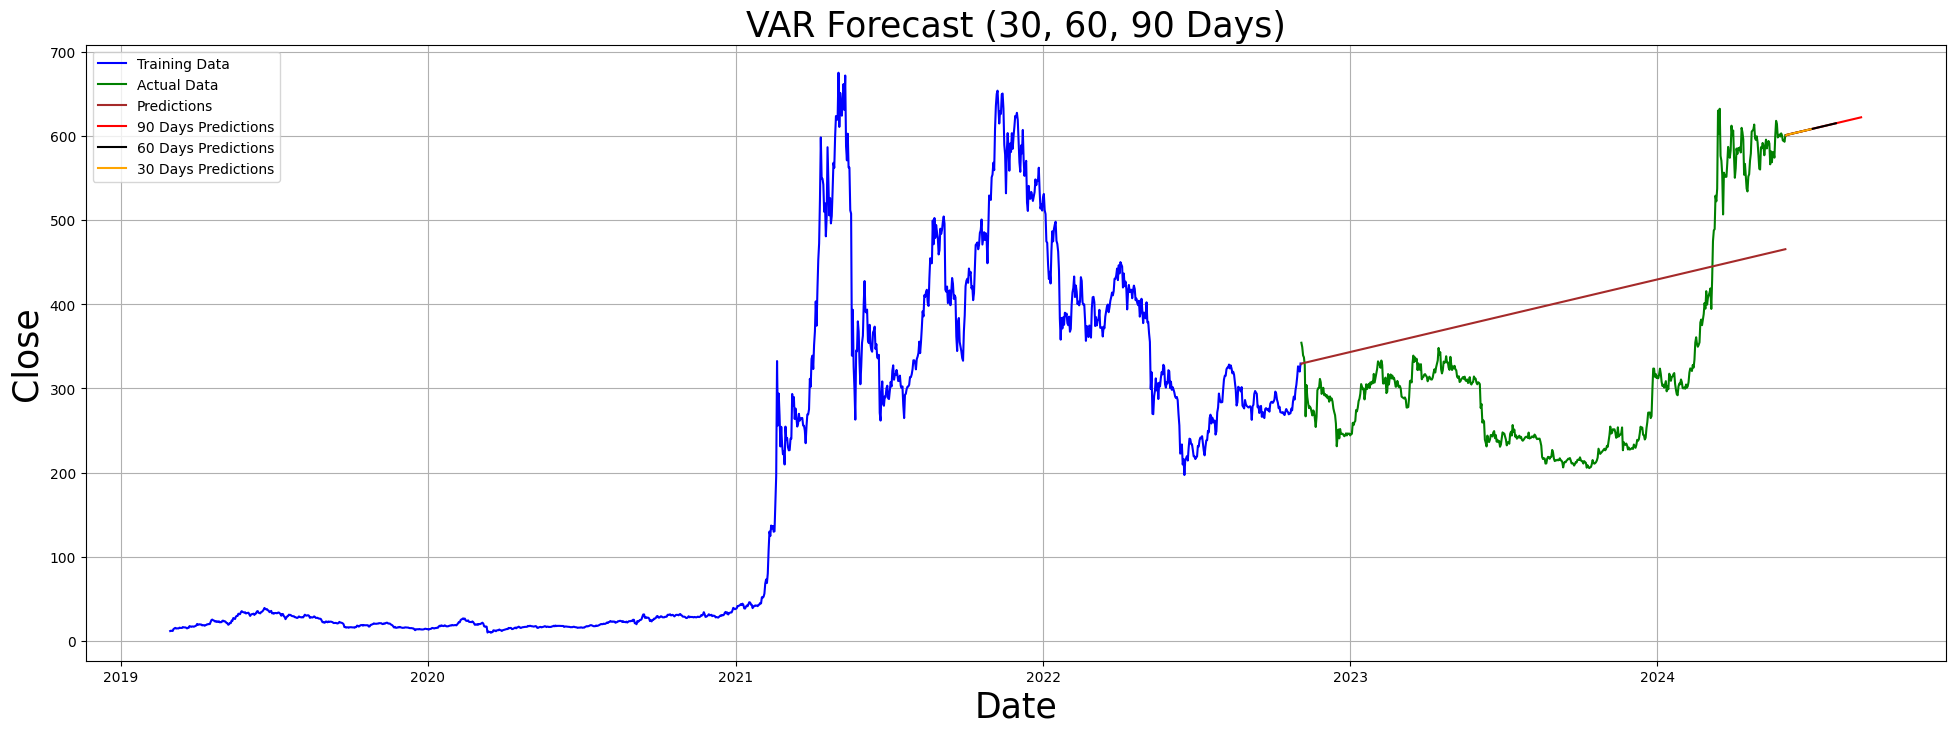

In [105]:
import matplotlib.pyplot as plt

# Assuming df_results_30days, df_results_60days, df_results_90days are your DataFrames containing forecast results
# Define the date range for plotting
start_date = '2019-01-03'
end_date = '2024-08-30'

# Plotting the data
plt.figure(figsize=(24, 8))

# Plotting the training data
plt.plot(train_data.index, train_data.Close, label='Training Data', color='blue')

# Plotting the actual test data
plt.plot(test_data.index, test_data.Close, label='Actual Data', color='green')
# Plotting the prediction data
plt.plot(test_data.index, df_results.Close_forecast, label='Predictions', color ='brown')
# Plotting the forecast results

plt.plot(df_results_90days.index, df_results_90days.Close_forecast, label='90 Days Predictions', color='red')

plt.plot(df_results_60days.index, df_results_60days.Close_forecast, label='60 Days Predictions', color='black')
plt.plot(df_results_30days.index, df_results_30days.Close_forecast, label='30 Days Predictions', color='orange')
# Adding title and labels
plt.title('VAR Forecast (30, 60, 90 Days)', fontsize=25)
plt.xlabel('Date', fontsize=25)
plt.ylabel('Close', fontsize=25)

# Adding legend and grid
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


In [106]:
y_test = test_data.Close
y_pred = df_results.Close_forecast

In [107]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np



test_91_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_91_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
test_91_mse = np.mean((np.array(y_test) - np.array(y_pred))**2)
print('Testing RMSE:', test_91_rmse)
print('Testing MAPE:', test_91_mape)
print('Testing MSE:', test_91_mse)

Testing RMSE: 125.46015560834665
Testing MAPE: 40.63479859042442
Testing MSE: 15740.250645270555
